# Design an image classification experiment 

Use the code in the notebook on **Online dataset construction** to create an image classification experiment with two classes.

You must:

1. Define a Google images query pair to generate your annotated dataset. Some suggestions (**WARN:** do not use blanks in your queries, use underscores instead)

    - plant/tree
    - nature/city
    - futbol/baloncesto
    - doritos/detodito
    - people_with_glasses/portrait
    

2. Define 3 or 4 CNN architectures with increasing complexity. You must select a query pair so that as you increase CNN complexity classification accuracy improves. Suggestions for variations for tour experiment:

    - images 64x64 or 128x128 resolution.
    - increase the number of images.
    - increase layers (convolutional and/or dense).
    - add pooling if your network becomes too large or you see overfitting.
    - increase dropout among layers if you see overfitting.


**IN YOUR EXPERIMENT THERE MUST BE AN EVIDENCE OF ACCURACY IMPROVEMENT IN TEST DATA AS YOU INCREASE THE COMPLEXITY OF YOUR CNN ARCHITECTURE**. For this, you will need to iterate several times until you select an appropriate Google images query pair so that the visual classification task beholds the appropriate complexity.


In [1]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mlutils
%matplotlib inline

/opt/miniconda/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
!pip install google_images_download

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.


In [3]:
downloads = "/tmp/downloads"
traintest_imgs = "/tmp/imgs"

train_pct = .7

In [4]:
!rm -rf $downloads
!mkdir $downloads

In [5]:
cfg="""
{
    "Records": [
        {
            "keywords": "futbol",
            "format": "jpg",
            "limit": 100,
            "type": "photo",
            "size": "medium",
            "output_directory": "%s"
        },
        {
            "keywords": "baloncesto",
            "format": "jpg",
            "limit": 100,
            "type": "photo",
            "size": "medium", 
            "output_directory": "%s"
        }
    ]
}
"""%(downloads, downloads)

In [6]:
with open(downloads+"/cfg.txt", "w") as f:
    f.write(cfg)

In [7]:
!googleimagesdownload --config_file $downloads/cfg.txt


Item no.: 1 --> Item name = futbol
Evaluating...
Starting Download...
Completed Image ====> 1. img_pmorata_20160831-202850_imagenes_md_propias_pmorata_ft1a0270-kgci-u434026677189fcf-980x554@mundodeportivo-web.jpg
Completed Image ====> 2. 15515455557396.jpg
Completed Image ====> 3. 20181027-636762708633008967_20181027210310882-k97-u452553888311agh-980x554@mundodeportivo-web.jpg
Completed Image ====> 4. 15244846684179.jpg
Completed Image ====> 5. 1075284434.jpg
Completed Image ====> 6. _20180318184353-kq7-u441604623659bcd-992x558@lavanguardia-web.jpg
Completed Image ====> 7. f%c3%batbol.jpg
Completed Image ====> 8. 1547574557_284167_1547750492_noticia_normal.jpg
Completed Image ====> 9. 15315961225160.jpg
Completed Image ====> 10. img_fmartinez_20181109-171424_imagenes_lv_getty_gettyimages-1053237084_4_5_2811569930-kfgh-u452803143087cnb-992x558@lavanguardia-web.jpg
Completed Image ====> 11. mundial-futbol-pymes-foto-post.jpg
Completed Image ====> 12. 15404135014679.jpg
Completed Image =

Completed Image ====> 26. seleccion-kuub--620x349@abc.jpg
Completed Image ====> 27. 670x390el_bote_14052015.jpg
Completed Image ====> 28. 33352749356_aeaedd1e78_k-e1503998421887-1024x561.jpg
Completed Image ====> 29. baloncesto.jpg
Completed Image ====> 30. baloncesto-1-e1551134233923.jpg
Completed Image ====> 31. numero-de-jugadores-en-un-equipo-de-baloncesto.jpg
Completed Image ====> 32. la-verdadera-historia-del-baloncesto-680x350.jpg
Completed Image ====> 33. liga-entesa-acb.jpg
Completed Image ====> 34. image_content_31542324_20180802162756.jpg
Completed Image ====> 35. baloncesto-ataque-llegar-jugando-1024x640.jpg
Completed Image ====> 36. 1504053861638313143.jpg
Completed Image ====> 37. baloncesto-3-e1551134522457.jpg
Completed Image ====> 38. 83ae4-baloncesto-colombia-2-web.jpg
Completed Image ====> 39. 15527350291774.jpg
Completed Image ====> 40. t2sdata66122714.jpg
Completed Image ====> 41. baloncesto.jpg
Completed Image ====> 42. image_content_8708480_20180928164404.jpg
Com

## THIS NOTEBOOK MUST BE SELF CONTAINED

include all code to download and prepare images, together with your network models and training

In [8]:
classdirs = !find $downloads -type d
classdirs = [i.split("/")[-1] for i in classdirs if i!=downloads]
print classdirs

['baloncesto', 'futbol']


In [9]:
!rm -rf $traintest_imgs

In [10]:
for classdir in classdirs:
    print classdir
    print "    splitting files ... ",
    files = !find $downloads/$classdir -type f
    files = np.r_[files]
    n_train = int(len(files)*train_pct)
    files = np.random.permutation(files)
    files_train = files[:n_train]
    files_test  = files[n_train:]
    !mkdir -p $traintest_imgs/train/$classdir
    !mkdir -p $traintest_imgs/test/$classdir
    print "copying files"
    for f in files_train:
        !cp '$f' $traintest_imgs/train/$classdir
    for f in files_test:
        !cp '$f' $traintest_imgs/test/$classdir

baloncesto
    splitting files ...  copying files
futbol
    splitting files ...  copying files


In [92]:
for classdir in classdirs:
    print classdir
    files = !find  $traintest_imgs/train/$classdir -type f
    print "      ",len(files), "train images"
    files = !find  $traintest_imgs/test/$classdir -type f
    print "      ",len(files), "test images"

baloncesto
       67 train images
       30 test images
futbol
       67 train images
       29 test images


In [93]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [94]:
datagen = ImageDataGenerator(rescale=1./255, fill_mode='nearest')
batch_size = 10
img_size = 32
train_generator_fn = lambda: datagen.flow_from_directory(
        traintest_imgs+"/train",  # this is the target directory
        target_size=(img_size, img_size),  # all images will be resized to 150x150
        batch_size=batch_size,
        interpolation = "bilinear",
        class_mode='binary') 

test_generator_fn = lambda: datagen.flow_from_directory(
        traintest_imgs+"/test",  # this is the target directory
        target_size=(img_size, img_size),  # all images will be resized to 150x150
        batch_size=batch_size,
        interpolation = "bilinear",
        class_mode='binary') 

Found 133 images belonging to 2 classes.


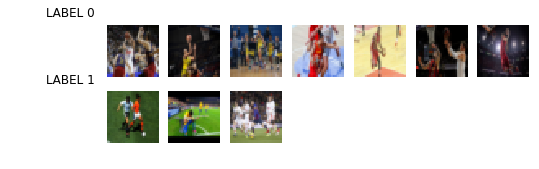

In [95]:
for imgs,labels in train_generator_fn():
    if np.random.random()>.5:
        break
reload(mlutils)        
mlutils.show_labeled_image_mosaic(imgs, labels)

TRAIN

In [96]:
def get_conv_model_A(num_classes, img_size=32, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(15,(10,10), activation="relu")(inputs)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [97]:
num_classes = len(classdirs)
model = get_conv_model_A(num_classes, img_size=img_size)

model.fit_generator(
        train_generator_fn(),
        steps_per_epoch=1000 // batch_size,
        epochs=3,
        validation_data=test_generator_fn(),
        validation_steps=400 // batch_size)

using 2 classes
Found 133 images belonging to 2 classes.
Found 58 images belonging to 2 classes.
Epoch 1/3
100/100 [==============================] - 13s 131ms/step - loss: 0.3459 - acc: 0.8629 - val_loss: 0.2068 - val_acc: 0.9459
Epoch 2/3
100/100 [==============================] - 12s 116ms/step - loss: 0.1093 - acc: 0.9590 - val_loss: 0.1853 - val_acc: 0.9356
Epoch 3/3
100/100 [==============================] - 12s 115ms/step - loss: 0.0303 - acc: 0.9950 - val_loss: 0.2209 - val_acc: 0.9639


In [98]:
def show_preds(x, preds):
    for i  in np.random.permutation(range(len(preds)))[:4]:
        plt.figure(figsize=(5,2.5))
        plt.subplot(122)
        plt.imshow(x[i])
        plt.axis("off")
        plt.subplot(121)
        plt.bar(np.arange(2), preds[i], color="blue", alpha=.5, label="prediction")
        plt.bar(np.arange(2), np.eye(2,2)[int(y[i])], color="red", alpha=.5, label="label")
        plt.xticks(range(2), range(2), rotation="vertical");
        plt.xlim(-.5,1.5);
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, +1.35),ncol=5)


Found 58 images belonging to 2 classes.


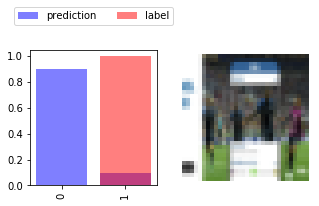

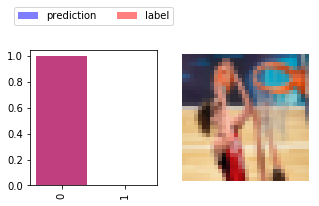

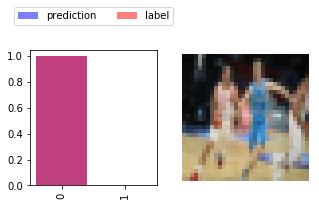

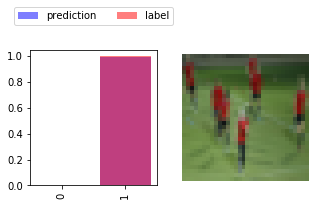

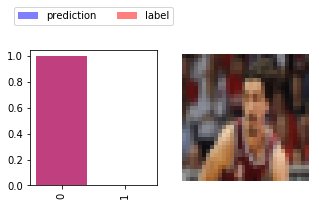

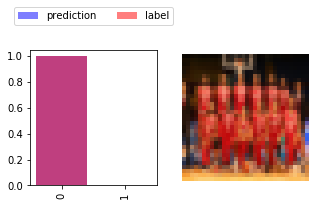

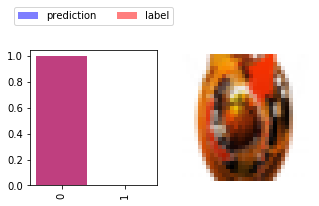

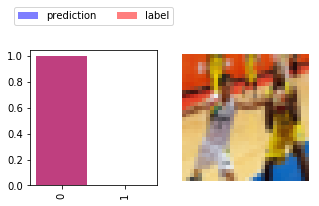

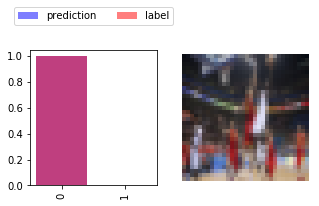

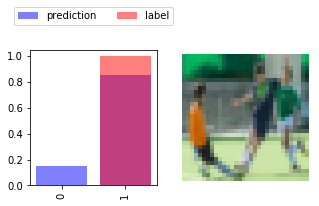

In [99]:
for x,y in test_generator_fn():
    if np.random.random()>.7:
        break
        
preds = model.predict(x)
mlutils.show_preds(x, y, preds)

Let's try a more complex network

In [102]:
def get_conv_model_B(num_classes, img_size=32, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(15,(10,10), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(60,(5,5), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

In [103]:
num_classes = len(classdirs)
model = get_conv_model_A(num_classes, img_size=img_size)

model.fit_generator(
        train_generator_fn(),
        steps_per_epoch=1000 // batch_size,
        epochs=3,
        validation_data=test_generator_fn(),
        validation_steps=400 // batch_size)

using 2 classes
Found 133 images belonging to 2 classes.
Found 58 images belonging to 2 classes.
Epoch 1/3
100/100 [==============================] - 13s 133ms/step - loss: 0.3123 - acc: 0.8510 - val_loss: 0.4151 - val_acc: 0.8789
Epoch 2/3
100/100 [==============================] - 12s 121ms/step - loss: 0.0964 - acc: 0.9700 - val_loss: 0.1528 - val_acc: 0.9510
Epoch 3/3
100/100 [==============================] - 12s 120ms/step - loss: 0.0256 - acc: 0.9930 - val_loss: 0.1596 - val_acc: 0.9665


In [104]:
def show_preds(x, preds):
    for i  in np.random.permutation(range(len(preds)))[:4]:
        plt.figure(figsize=(5,2.5))
        plt.subplot(122)
        plt.imshow(x[i])
        plt.axis("off")
        plt.subplot(121)
        plt.bar(np.arange(2), preds[i], color="blue", alpha=.5, label="prediction")
        plt.bar(np.arange(2), np.eye(2,2)[int(y[i])], color="red", alpha=.5, label="label")
        plt.xticks(range(2), range(2), rotation="vertical");
        plt.xlim(-.5,1.5);
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, +1.35),ncol=5)


Found 58 images belonging to 2 classes.


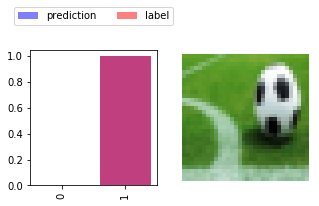

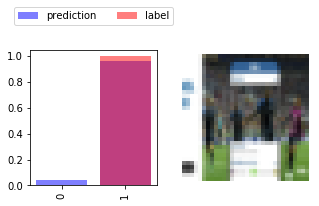

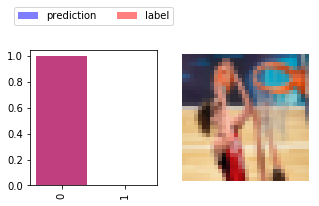

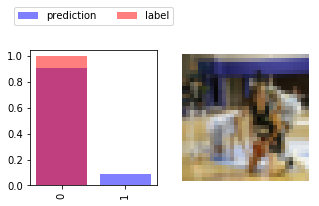

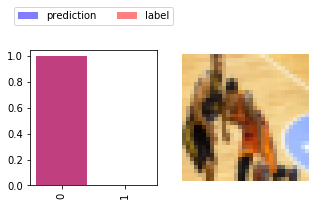

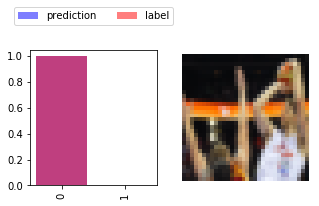

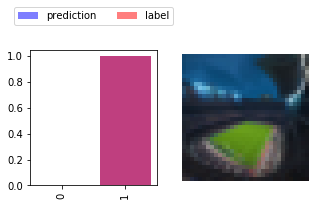

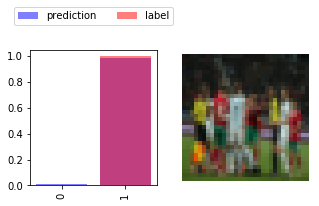

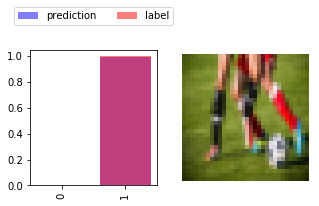

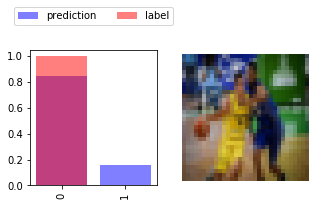

In [105]:
for x,y in test_generator_fn():
    if np.random.random()>.7:
        break
        
preds = model.predict(x)
mlutils.show_preds(x, y, preds)

In [106]:
def get_conv_model_C(num_classes, img_size=32, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(60,(11,11), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [107]:
num_classes = len(classdirs)
model = get_conv_model_A(num_classes, img_size=img_size)

model.fit_generator(
        train_generator_fn(),
        steps_per_epoch=1000 // batch_size,
        epochs=3,
        validation_data=test_generator_fn(),
        validation_steps=400 // batch_size)

using 2 classes
Found 133 images belonging to 2 classes.
Found 58 images belonging to 2 classes.
Epoch 1/3
100/100 [==============================] - 13s 133ms/step - loss: 0.4173 - acc: 0.8034 - val_loss: 0.2400 - val_acc: 0.8814
Epoch 2/3
100/100 [==============================] - 12s 116ms/step - loss: 0.1127 - acc: 0.9620 - val_loss: 0.1236 - val_acc: 0.9639
Epoch 3/3
100/100 [==============================] - 12s 123ms/step - loss: 0.0718 - acc: 0.9700 - val_loss: 0.1504 - val_acc: 0.9820


In [108]:
def show_preds(x, preds):
    for i  in np.random.permutation(range(len(preds)))[:4]:
        plt.figure(figsize=(5,2.5))
        plt.subplot(122)
        plt.imshow(x[i])
        plt.axis("off")
        plt.subplot(121)
        plt.bar(np.arange(2), preds[i], color="blue", alpha=.5, label="prediction")
        plt.bar(np.arange(2), np.eye(2,2)[int(y[i])], color="red", alpha=.5, label="label")
        plt.xticks(range(2), range(2), rotation="vertical");
        plt.xlim(-.5,1.5);
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, +1.35),ncol=5)


Found 58 images belonging to 2 classes.


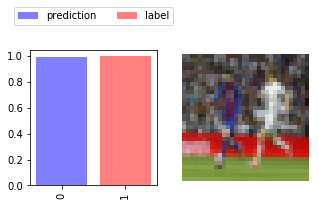

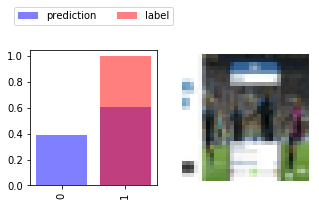

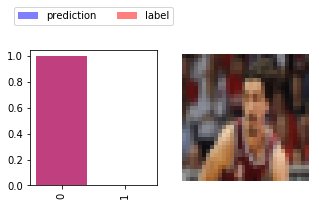

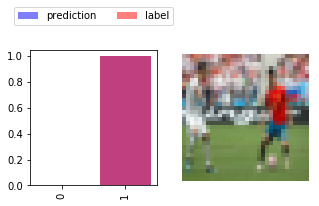

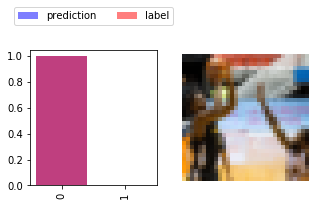

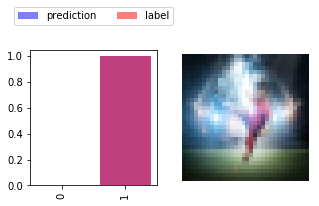

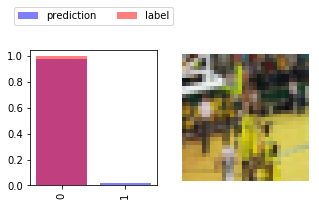

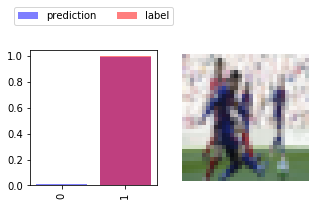

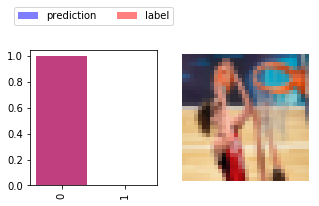

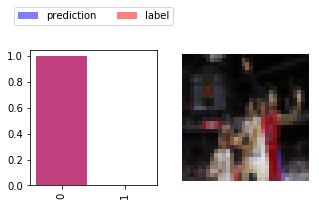

In [109]:
for x,y in test_generator_fn():
    if np.random.random()>.7:
        break
        
preds = model.predict(x)
mlutils.show_preds(x, y, preds)